## Install necessary libaries for benchmarking speech to text with GPU T4x2

In [17]:
# Install torch with CUDA support
!pip install cuda-python
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

# Install Whisper
!pip install git+https://github.com/openai/whisper.git

# Install dotenv for environment variable management
!pip install python-dotenv

# Install OpenAI Python client library
!pip install openai

# Install Groq library
!pip install groq

Looking in indexes: https://download.pytorch.org/whl/cu118
  Cloning https://github.com/openai/whisper.git to /tmp/pip-req-build-w94ksg3p
  Running command git clone --filter=blob:none --quiet https://github.com/openai/whisper.git /tmp/pip-req-build-w94ksg3p
  Resolved https://github.com/openai/whisper.git to commit 90db0de1896c23cbfaf0c58bc2d30665f709f170
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [18]:
import torch

# Check GPU availability
device = "cuda" if torch.cuda.is_available() else "cpu"
if device == "cuda":
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    print("GPU not available. Using CPU.")

Using GPU: Tesla T4


# Speech to Text code

In [19]:
import os
import time
import whisper
import torch
import warnings
from dotenv import load_dotenv
from openai import OpenAI
from groq import Groq

# Ignore the warning when using CPU
warnings.filterwarnings("ignore", message="You are using `torch.load` with `weights_only=False`")

# Load the API_Key
api_key = "OPENAI_API_KEY"
groq_api_key = "GROQ_API_KEY"

# Initialize the OpenAI client
client = OpenAI(api_key=api_key)

# Initialize the Groq client
groq_client = Groq(api_key=groq_api_key)

# Function to transcribe an audio file using OpenAI API with the whisper large model
def transcribe_audio_with_openai(audio_file: str) -> str:
    try:
        with open(audio_file, "rb") as file:
            transcription = client.audio.transcriptions.create(
                model="whisper-1", 
                file=file
            )
        return transcription.text
    except Exception as e:
        print(f"An error occurred: {e}")
        return ""

# Function to transcribe an audio file using Groq API with the whisper large model
def transcribe_audio_with_groq(audio_file: str) -> str:
    try:
        with open(audio_file, "rb") as file:
            transcription = groq_client.audio.transcriptions.create(
                file=(audio_file, file.read()),
                model="whisper-large-v3-turbo",
                response_format="verbose_json",
            )
        return transcription.text
    except Exception as e:
        print(f"An error occurred: {e}")
        return ""
    
# Function to transcribe an audio file using Whisper model running locally
def transcribe_audio_with_whisper_local(audio_file: str) -> str:
    try:
        # Check for CUDA availability, otherwise fallback to CPU
        device = "cuda" if torch.cuda.is_available() else "cpu"
        print(f"Using device: {device}")

        # Load the Whisper large model - turbo version is optimized for speed
        model = whisper.load_model("turbo", device=device)

        # Perform transcription
        if(device == "cpu"):
            result = model.transcribe(audio_file, fp16=False)
        else:
            result = model.transcribe(audio_file, fp16=True)
        return result["text"]
    except Exception as e:
        print(f"An error occurred: {e}")
        return ""


Processing /kaggle/input/audio-benchmark-12/audio_0.wav...
OpenAI Transcription: 저희 머랭구에서 완전 스테디셀러 4년째 정말 정말 인기가 나는 제품이래요 근데 제가 딱 신점 하나 느꼈어요
OpenAI Transcription Time: 1.22 seconds
Groq Transcription:  머랭고에서 완전 스테디셀러 4년째 정말 정말 인기가 나는 제품이래요 근데 제가 딱 신점을 느낀 것 같아요
Groq Transcription Time: 0.48 seconds
Using device: cuda
Whisper Local Transcription:  저희 머랭고에서 완전 스테디셀러 4년째 정말 정말 인기가 나는 제품이래요 근데 제가 딱 신점하듯
Whisper Local Transcription Time: 14.48 seconds

Processing /kaggle/input/audio-benchmark-12/audio_1.wav...
OpenAI Transcription: 아니 그럴 수밖에 없겠다. 아니 만약에 전 그럴 것 같아요. 제가 블랙 하나 사서 1년, 2년 너무 잘 씻었어. 그럼 내년에 가을에 되면
OpenAI Transcription Time: 1.77 seconds
Groq Transcription:  아니 그럴 수밖에 없겠다 아니 만약에 전 그럴 거 같아요 제가 블랙 하나 사서 1년 2년 너무 잘 씻었어 그럼 내년에 가을끝에 되면
Groq Transcription Time: 0.45 seconds
Using device: cuda
Whisper Local Transcription:  아니 그럴 수밖에 없겠다. 아니 만약에 전 그럴 것 같아요. 제가 블랙 하나 사서 1년, 2년 너무 잘 씻었어. 그럼 내년에 가을에 되면
Whisper Local Transcription Time: 12.71 seconds

Processing /kaggle/input/audio-benchmark-1

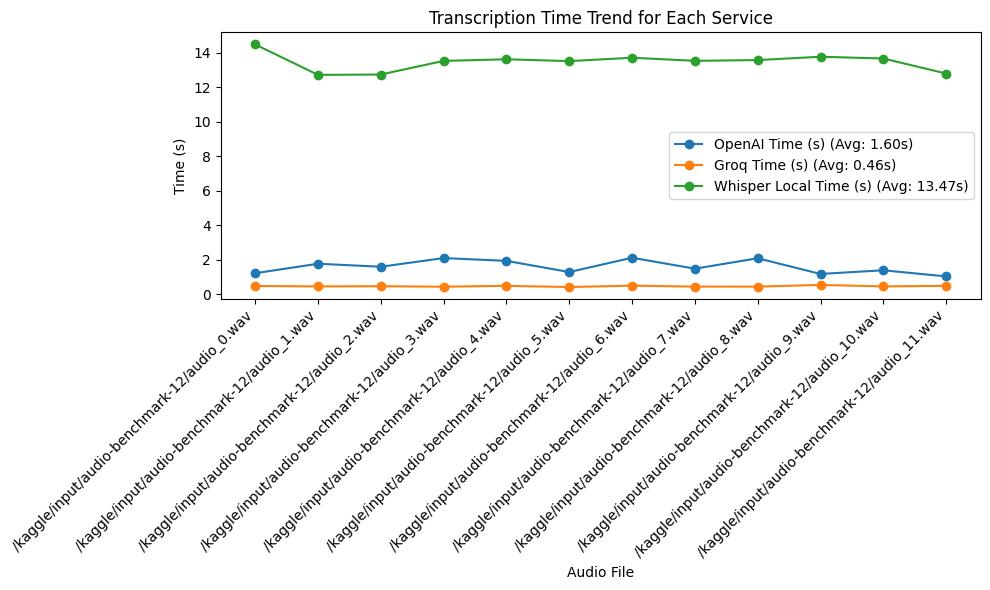


Transcription times with trends saved to 'transcription_times_with_trends.csv'.


In [20]:
import time
import pandas as pd
import matplotlib.pyplot as plt

# List of audio file paths
audio_files = [f"/kaggle/input/audio-benchmark-12/audio_{i}.wav" for i in range(12)]

# Initialize a dictionary to store processing times
results = {
    "Audio File": [],
    "OpenAI Time (s)": [],
    "Groq Time (s)": [],
    "Whisper Local Time (s)": []
}

if __name__ == "__main__":
    for audio_file_path in audio_files:
        print(f"\nProcessing {audio_file_path}...")
        
        # Append audio file name
        results["Audio File"].append(audio_file_path)

        # Measure time for OpenAI transcription
        try:
            start_time = time.time()
            transcription_text = transcribe_audio_with_openai(audio_file_path)
            openai_duration = time.time() - start_time
            if transcription_text:
                print(f"OpenAI Transcription: {transcription_text}")
            print(f"OpenAI Transcription Time: {openai_duration:.2f} seconds")
        except Exception as e:
            print(f"OpenAI Transcription Error: {e}")
            openai_duration = None
        results["OpenAI Time (s)"].append(openai_duration)

        # Measure time for Groq transcription
        try:
            start_time = time.time()
            transcription_text_groq = transcribe_audio_with_groq(audio_file_path)
            groq_duration = time.time() - start_time
            if transcription_text_groq:
                print(f"Groq Transcription: {transcription_text_groq}")
            print(f"Groq Transcription Time: {groq_duration:.2f} seconds")
        except Exception as e:
            print(f"Groq Transcription Error: {e}")
            groq_duration = None
        results["Groq Time (s)"].append(groq_duration)

        # Measure time for Whisper local transcription
        try:
            start_time = time.time()
            transcription_text_whisper_local = transcribe_audio_with_whisper_local(audio_file_path)
            whisper_local_duration = time.time() - start_time
            if transcription_text_whisper_local:
                print(f"Whisper Local Transcription: {transcription_text_whisper_local}")
            print(f"Whisper Local Transcription Time: {whisper_local_duration:.2f} seconds")
        except Exception as e:
            print(f"Whisper Local Transcription Error: {e}")
            whisper_local_duration = None
        results["Whisper Local Time (s)"].append(whisper_local_duration)

    # Convert results dictionary to a DataFrame
    df_results = pd.DataFrame(results)

    # Calculate average time for each service
    average_times = df_results.mean(numeric_only=True).to_dict()
    print("\nAverage Transcription Times:")
    for service, avg_time in average_times.items():
        print(f"{service}: {avg_time:.2f} seconds")

    # Visualization with trend lines
    plt.figure(figsize=(10, 6))

    # Plot trend lines for each service
    for service in ["OpenAI Time (s)", "Groq Time (s)", "Whisper Local Time (s)"]:
        plt.plot(df_results["Audio File"], df_results[service], marker='o', label=f"{service} (Avg: {average_times[service]:.2f}s)")

    # Customize the plot
    plt.title("Transcription Time Trend for Each Service")
    plt.ylabel("Time (s)")
    plt.xlabel("Audio File")
    plt.xticks(rotation=45, ha="right")
    plt.legend()
    plt.tight_layout()

    # Save and show the plot
    plt.savefig("transcription_time_trend.png")
    plt.show()

    # Save results to a CSV file
    df_results.to_csv("transcription_times_with_trends.csv", index=False)
    print("\nTranscription times with trends saved to 'transcription_times_with_trends.csv'.")

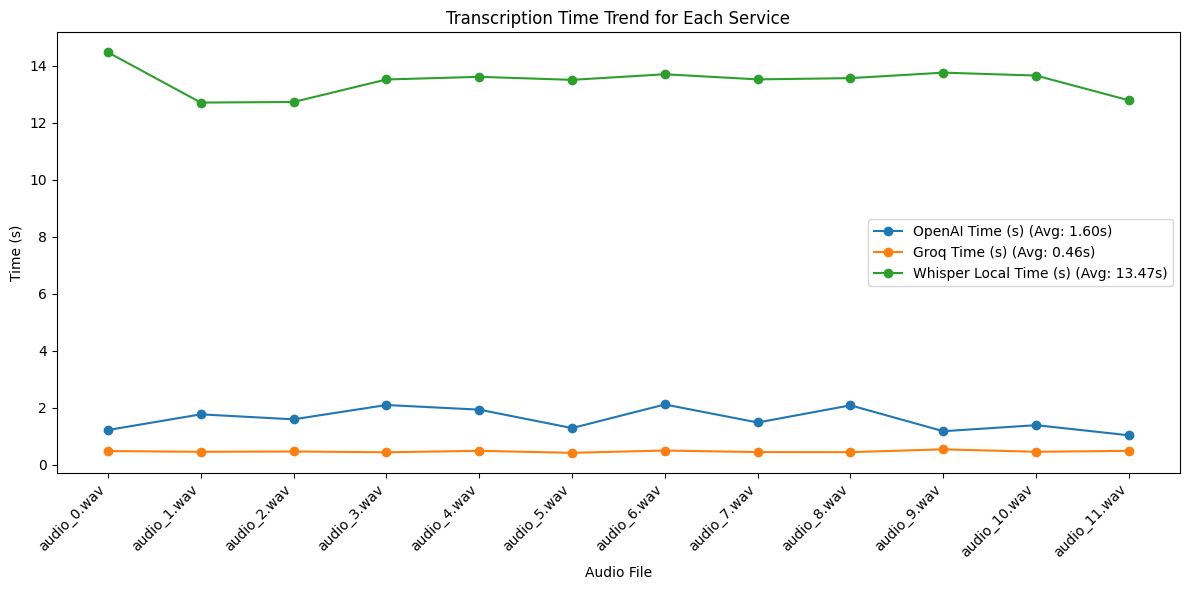

In [22]:
import os  # For extracting file names

# Shorten the audio file paths for better readability
df_results["Audio File"] = df_results["Audio File"].apply(lambda x: os.path.basename(x))

# Visualization with trend lines
plt.figure(figsize=(12, 6))

# Plot trend lines for each service
for service in ["OpenAI Time (s)", "Groq Time (s)", "Whisper Local Time (s)"]:
    plt.plot(df_results["Audio File"], df_results[service], marker='o', label=f"{service} (Avg: {average_times[service]:.2f}s)")

# Customize the plot
plt.title("Transcription Time Trend for Each Service")
plt.ylabel("Time (s)")
plt.xlabel("Audio File")
plt.xticks(rotation=45, ha="right")
plt.legend()
plt.tight_layout()

# Save and show the plot
plt.savefig("transcription_time_trend_clean.png")
plt.show()